# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## Data Preprocessing

In [2]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

## ACF-PACF

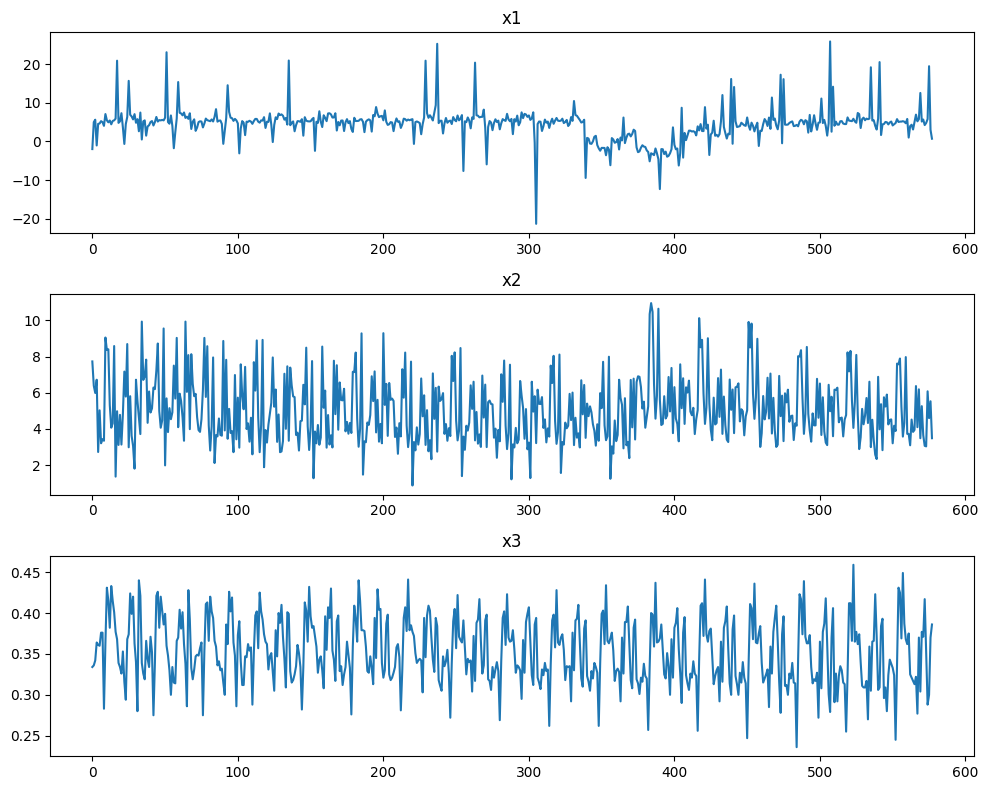

In [3]:
num_col= len(data.columns)

# Create a figure and plot each column using a loop
plt.figure(figsize=(10, 8))

for i, column in enumerate(data.columns):
    plt.subplot(num_col, 1, i + 1)
    plt.plot(data[column])
    plt.title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

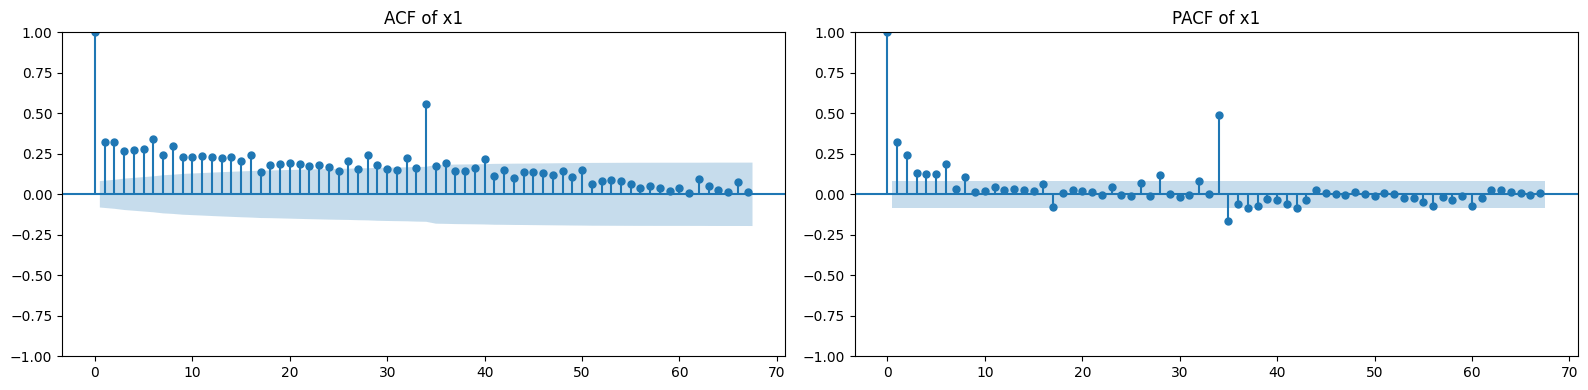

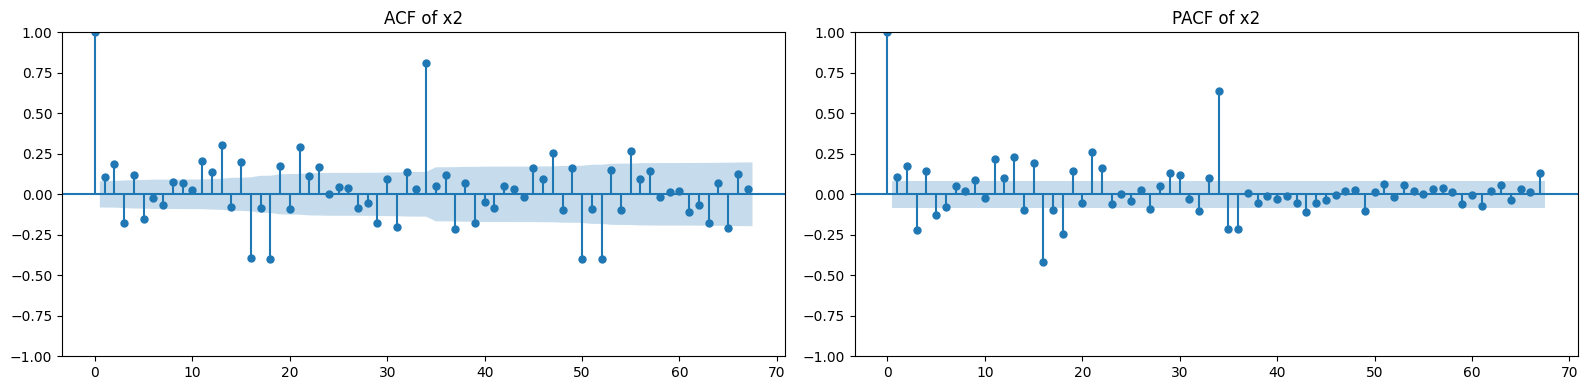

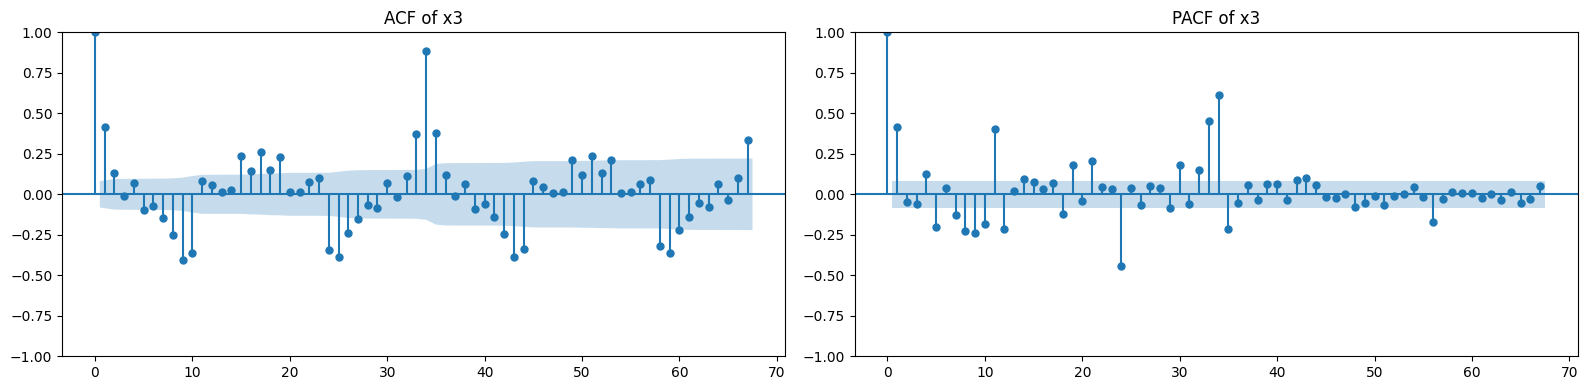

In [4]:
for column in data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Plot ACF
    plot_acf(data[column], ax=axes[0], lags=67)
    axes[0].set_title(f'ACF of {column}')
    
    # Plot PACF
    plot_pacf(data[column], ax=axes[1], lags=67)
    axes[1].set_title(f'PACF of {column}')
    
    # Display the plots
    plt.tight_layout()
    plt.show()

## 5. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

## 6. Standarization

In [5]:
from sklearn.preprocessing import StandardScaler

def standardize_data(data):
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data)
    return data_norm

data_norm = standardize_data(data)

## 7. Data Splitting

In [6]:
def windowed_dataset(series, batch_size, n_past=34, n_future=34, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
BATCH_SIZE = 4
N_PAST = 34
N_FUTURE = 34
SHIFT = 1
N_FEATURES = len(data.columns)
SPLIT_TIME = 442

In [8]:
x_train = data_norm[:SPLIT_TIME]
x_test = data_norm[SPLIT_TIME:]
tf.keras.backend.clear_session()
tf.random.set_seed(1)

train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                            n_past=N_PAST, n_future=N_FUTURE,
                            shift=SHIFT)
test_set = windowed_dataset(series=x_test, batch_size=BATCH_SIZE,
                            n_past=N_PAST, n_future=N_FUTURE,
                            shift=SHIFT)

## 8. Neural Network Architecture

In [21]:
def mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Small value to avoid division by zero
    y_true = tf.maximum(y_true, epsilon)
    
    # Calculate MAPE
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [26]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(N_PAST, N_FEATURES)),
                tf.keras.layers.Dense(hidden_node, input_shape=(N_PAST, N_FEATURES), activation=activation),
                tf.keras.layers.Dense(N_FEATURES)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)
        if __name__ == '__main__':
                model.save(f"model_{hidden_node}.h5")
        final_loss = history.history['val_loss'][-1]
        return final_loss

losses = []
        

In [27]:
for hidden_node in range(1, 21):
    final_loss = modelling(train_dataset=train_set, 
                test_dataset=test_set, 
                epoch=10, 
                loss_function=mape, 
                optimizer='Adam',
                activation='relu',
                hidden_node=hidden_node)
    losses.append({'Hidden Nodes': hidden_node, 'Loss': final_loss})

Epoch 1/10
94/94 [==============================] - 1s 4ms/step - loss: 76811336.0000 - val_loss: 29407354.0000
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 53469036.0000 - val_loss: 20566140.0000
Epoch 3/10
94/94 [==============================] - 0s 3ms/step - loss: 37134924.0000 - val_loss: 14053582.0000
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 25186152.0000 - val_loss: 8509037.0000
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 16009923.0000 - val_loss: 5161154.0000
Epoch 6/10
94/94 [==============================] - 0s 2ms/step - loss: 10361863.0000 - val_loss: 3439862.7500
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 6788806.0000 - val_loss: 2286762.0000
Epoch 8/10
94/94 [==============================] - 0s 2ms/step - loss: 4203171.5000 - val_loss: 1402439.0000
Epoch 9/10
94/94 [==============================] - 0s 2ms/step - loss: 3092388.5000 - val_loss: 1050504.3750
E

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 1s 4ms/step - loss: 84136736.0000 - val_loss: 39273012.0000
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 58935404.0000 - val_loss: 28102352.0000
Epoch 3/10
94/94 [==============================] - 0s 2ms/step - loss: 42338200.0000 - val_loss: 18498354.0000
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 29504330.0000 - val_loss: 11696827.0000
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 21574986.0000 - val_loss: 7489398.0000
Epoch 6/10
94/94 [==============================] - 0s 3ms/step - loss: 16104447.0000 - val_loss: 5399618.0000
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 12098000.0000 - val_loss: 3210464.5000
Epoch 8/10
94/94 [==============================] - 0s 2ms/step - loss: 8883567.0000 - val_loss: 2098134.0000
Epoch 9/10
94/94 [==============================] - 0s 2ms/step - loss: 6425917.5000 - val_loss: 1089254.1250
Epoch 10/1

In [33]:
losses_df = pd.DataFrame(losses)

# Display the accumulated losses
print(losses_df)

    Hidden Nodes          Loss
0              1  7.002176e+05
1              2  4.658242e+05
2              3  9.673612e+05
3              4  5.494749e+06
4              5  8.686655e+06
5              6  9.710656e+05
6              7  5.691458e+06
7              8  6.366554e+06
8              9  1.089367e+07
9             10  1.043610e+07
10            11  6.491166e+06
11            12  4.615964e+06
12            13  1.100368e+07
13            14  5.477755e+06
14            15  1.115641e+07
15            16  5.275270e+06
16            17  8.616187e+06
17            18  5.355590e+06
18            19  5.445629e+06
19            20  6.775186e+06


In [32]:
def display_model_equation(model_filename, hidden_node, activation):
    # Load the model
    model = tf.keras.models.load_model(model_filename)
    
    print(f"\nMathematical equation for the model with {hidden_node} hidden nodes and {activation} activation:")
    
    # Print the equation for each layer
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            weights = np.squeeze(weights)
            biases = np.squeeze(biases)
            if i == 0:
                print("y = ", end="")
                for j in range(len(weights)):
                    print(f"relu({weights[j]} * x{j} + {biases[j]}) + ", end="")
            else:
                print(f"{weights} * relu(W{j} * x{j} + b{j}) + {biases}")
        elif isinstance(layer, tf.keras.layers.InputLayer):
            continue  # Skip InputLayer
        else:
            raise ValueError(f"Unexpected layer type: {layer.__class__.__name__}")

# Display the model equation for each model
for index, row in losses_df.iterrows():
    display_model_equation(row['Hidden Node'], row['Hidden Nodes'], activation)

KeyError: 'Model File'

In [11]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true.ravel() - y_pred.ravel()))


def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :]

x_valid = x_test[:rnn_forecast.shape[0]]
result = mae(x_valid, rnn_forecast)

NameError: name 'model' is not defined